#필요한 모듈 불러오기

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
from minisom import MiniSom
from tqdm import tqdm, tqdm_notebook, tnrange
import time
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager
from datetime import datetime as dt
from lxml.html import fromstring, tostring
from matplotlib import font_manager, rc
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
import gc
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline  

# 데이터프레임 결합

In [ ]:
pickle_path = "이커머스 FC주문 데이터.pickle"
month_3_path = "1-1. 이커머스 FC주문 데이터_3월.csv"
month_4_path = "1-2. 이커머스 FC주문 데이터_4월.csv"
month_5_path = "1-3. 이커머스 FC주문 데이터_5월.csv"
month_6_path = "1-4. 이커머스 FC주문 데이터_6월.csv"

In [ ]:
df_M3 = pd.read_csv(month_3_path, low_memory=False, parse_dates=['BKG_DATE','ORDER_CRT_DATETIME'])
df_M4 = pd.read_csv(month_4_path, low_memory=False, parse_dates=['BKG_DATE','ORDER_CRT_DATETIME'])
df_M5 = pd.read_csv(month_5_path, low_memory=False, parse_dates=['BKG_DATE','ORDER_CRT_DATETIME'])
df_M6 = pd.read_csv(month_6_path, low_memory=False, parse_dates=['BKG_DATE','ORDER_CRT_DATETIME'])

In [ ]:
df=pd.concat([df_M3,df_M4,df_M5,df_M6],ignore_index=True)


In [ ]:
del [df_M3,df_M4,df_M5,df_M6]
gc.collect()

40

In [ ]:
df['day']=df['BKG_DATE'].dt.dayofweek

In [ ]:
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns
df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786374 entries, 0 to 1786373
Data columns (total 33 columns):
 #   Column              Dtype         
---  ------              -----         
 0   CORP_ID             category      
 1   REF_ORD_NO          object        
 2   BKG_NO              object        
 3   BKG_TYP             int8          
 4   BKG_DATE            datetime64[ns]
 5   BKG_TIME            int32         
 6   SHPR_CD             int32         
 7   INV_AMT             float32       
 8   ITEM_SEQ            int8          
 9   ITEM_CD             object        
 10  BRAND_NM            object        
 11  ITEM_QTY            int32         
 12  ITEM_AMT            float32       
 13  IF_YN               object        
 14  ORDER_CRT_DATETIME  datetime64[ns]
 15  DLV_DV              float32       
 16  REF_ITEM_SEQ        object        
 17  ORDER_IDX           object        
 18  ORDER_YN            object        
 19  DLVPREARRBRANCD     object        
 20  DL

In [ ]:

df['day']=df['BKG_DATE'].dt.dayofweek

In [ ]:
with open(pickle_path, 'wb') as fw:
    pickle.dump(df, fw)


In [ ]:
with open(pickle_path, 'rb') as fr:
    df = pickle.load(fr)

# 날씨데이터 매핑

- 송화인 주소 통일

In [ ]:
dic = {'강원도':['강원'],
'경기도':['\t경기도', '(12730)', '(13279)', '(13499)', '(14782)', '[16817]', '경기', '경기도수원시', '경기도시흥시', '곤지암', '평택시', '화성시'],
'경상남도':['(53298)', '경남', '경삼남도'],
'경상북도':['경북', '상주시', '영천시', '태종로711번길'],
'광주광역시':['광주', '중구'],
'대구광역시':['대구', '대구시'],
'대전광역시':['대전'],
'부산광역시':['부산', '부산시'],
'서울특별시':['서울시', '道路名稱首爾特別市中區麻將路1街22號（STUDIO', '강서구', '마포구', '서울', '영등포구', '울특별시', '\u200b서울시'],
'세종특별자치시':['(30100)', '세종', '세종시', '종시'],
'울산광역시':['울산'],
'인천광역시':['(22738)', '인천', '인천광역시 서구 정서진로 47', '인천광역시미추홀구', '인천시', '인천광역시\xa0서구\xa0정서진로\xa047'],
'전라남도':['전남', '전남목포시'],
'전라북도':['전북'],
'제주도':['제주', '제주특별자치도'],
'충청남도':['청남도', '충남', '충남금산군'],
'충청북도':['청주시', '충북']}

In [ ]:
#각 지역별 대분류로 매핑
for key, value in dic.items():
    n = len(value)
    for i in range(n):
        df.loc[df['CNEE_ADDR_1'] == value[i],'CNEE_ADDR_1'] = key

In [ ]:
# CNEE_ADDR_1가 NaN이면 CNEE_ADDR_2의 값을 참조하여 채움
df.loc[(df["CNEE_ADDR_1"].isnull()) & (df["CNEE_ADDR_2"]=='경상남도'), 'CNEE_ADDR_1'] = '경상남도'
df.loc[(df["CNEE_ADDR_1"].isnull()) & (df["CNEE_ADDR_2"]=='충남공주시'), 'CNEE_ADDR_1'] = '충청남도'

In [ ]:
# CNEE_ADDR_1과 CNEE_ADDR_2가 모두 NaN이어서 알 수 없으므로 drop
df.dropna(subset = ['CNEE_ADDR_1'], axis=0, inplace=True)

- 날씨데이터 지점명 통일

In [ ]:
df_weather=pd.read_csv('날씨.csv') #날씨 Raw Data 가져오기

In [ ]:

dic={'강원도':['강릉','대관령','동해','북강릉','북춘천','삼척','속초','영월','원주','인제','정선군','철원','춘천','태백','홍천'],
'경기도':['동두천','수원','양평','이천','파주'],
'경상남도':['거제','거창','김해시','남해','밀양','북창원','산청','양산시','의령군','진주','창원','통영','함양군','합천'],
'경상북도':['경주시','구미','문경','봉화','상주','안동','영덕','영주','영천','울릉도','울진','의성','청송군','포항'],
'광주광역시':['광주'],
'대구광역시':['대구','대구(기)'],
'대전광역시':['대전'],
'부산광역시':['부산'],
'서울특별시':['관악산','서울'],
'세종특별자치시':['세종'],
'울산광역시':['울산'],
'인천광역시':['강화','백령도','인천'],
'전라남도':['강진군','고흥','광양시','목포','무안','보성군','순천','여수','영광군','완도','장흥','주암','진도(첨찰산)','진도군','해남','흑산도'],
'전라북도':['고창','고창군','군산','남원','부안','순창군','임실','장수','전주','정읍'],
'제주도':['고산','서귀포','성산','성산','성산포','제주'],
'충청남도':['금산','보령','부여','서산','천안','홍성'],
'충청북도':['보은','제천','청주','추풍령','충주']}


In [ ]:
#각 지역별 대분류로 매핑
for key,value in dic.items():
    n=len(value)
    for i in range(n):
        df_weather.loc[df_weather['지점명']==value[i],'지점명']=key

In [ ]:
df_weather['지점명'].value_counts().sum()
df1=df_weather.groupby(['지점명','일시']).mean().reset_index()
df1.drop('지점',axis=1,inplace=True)

In [ ]:
df1

,지점명,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),평균 전운량(1/10)
0,강원도,2021-03-01,2.692857,68.000000,2.135714,91.292857,9.915385
1,강원도,2021-03-02,-0.735714,3.653846,1.564286,83.457143,6.892308
2,강원도,2021-03-03,0.857143,NaN,1.200000,73.328571,4.438462
3,강원도,2021-03-04,4.028571,0.100000,1.007143,72.564286,7.484615
4,강원도,2021-03-05,6.571429,NaN,1.035714,70.171429,2.346154
...,...,...,...,...,...,...,...
2069,충청북도,2021-06-26,21.160000,7.960000,0.940000,83.640000,8.420000
2070,충청북도,2021-06-27,23.200000,NaN,1.440000,72.140000,6.220000
2071,충청북도,2021-06-28,22.880000,1.900000,1.620000,73.660000,6.920000
2072,충청북도,2021-06-29,22.860000,12.620000,1.200000,78.040000,6.220000


In [ ]:
df1['일시']=pd.to_datetime(df1['일시'])

In [ ]:
# 날씨데이터 수치 소수점 둘 째 자리까지 반올림
df1[['평균기온(°C)','일강수량(mm)','평균 풍속(m/s)','평균 상대습도(%)','평균 전운량(1/10)']]=\
df1[['평균기온(°C)','일강수량(mm)','평균 풍속(m/s)','평균 상대습도(%)','평균 전운량(1/10)']].round(2)
df1

,지점명,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),평균 전운량(1/10)
0,강원도,2021-03-01,2.69,68.00,2.14,91.29,9.92
1,강원도,2021-03-02,-0.74,3.65,1.56,83.46,6.89
2,강원도,2021-03-03,0.86,NaN,1.20,73.33,4.44
3,강원도,2021-03-04,4.03,0.10,1.01,72.56,7.48
4,강원도,2021-03-05,6.57,NaN,1.04,70.17,2.35
...,...,...,...,...,...,...,...
2069,충청북도,2021-06-26,21.16,7.96,0.94,83.64,8.42
2070,충청북도,2021-06-27,23.20,NaN,1.44,72.14,6.22
2071,충청북도,2021-06-28,22.88,1.90,1.62,73.66,6.92
2072,충청북도,2021-06-29,22.86,12.62,1.20,78.04,6.22


In [ ]:
#이커머스 데이터와 날씨 데이터 JOIN
df_wea_order=pd.merge(df,df1,left_on=['BKG_DATE','CNEE_ADDR_1'],right_on=['일시','지점명'])

# 컬럼 정제

In [ ]:
#결측치 0값으로 대체 
df_wea_order['일강수량(mm)'].fillna(value=0,inplace=True)
df_wea_order['평균 전운량(1/10)'].fillna(value=0,inplace=True)
#'ITEM_CD' 일련화               
df_wea_order['ITEM_CD'].replace('_\d','',regex=True,inplace=True)
df_wea_order['ITEM_CD'].replace('-\d','',regex=True,inplace=True)

In [ ]:
df_wea_order=df_wea_order[df_wea_order['BKG_TYP']==7]
df_wea_order.drop(
    columns=['REF_ITEM_SEQ','SHPR_ADDR_2','CNEE_ADDR_2','지점명','일시',\
             'ITEM_AMT','INV_AMT','BKG_TYP','BKG_TIME','ITEM_SEQ',\
             'BRAND_NM','IF_YN', 'ORDER_CRT_DATETIME','DLV_DV','ORDER_YN',\
             'DLVPREARRBRANCD', 'DLVPREARREMPNICKNM','DLVSUBCLSFCD','INS_ID','INS_DATE', \
             'INS_TIME','SPLIT_EXEC_YN','BKG_NO','REF_ORD_NO','DLVCLSFCD','POST_ZONE'] \
              , axis=1,inplace=True)
df_wea_order.reset_index(drop=True,inplace=True)

In [ ]:
df_wea_order.rename(columns={'평균기온(°C)':'평균기온'\
                             ,'일강수량(mm)':'평균강수량'\
                             ,'평균 풍속(m/s)':'평균풍속'\
                             ,'평균 상대습도(%)':'평균습도'\
                             ,'평균 전운량(1/10)':'평균전운량'},inplace=True)

In [ ]:
def 체감온도(T,V):
    V=V*3.6
    return round(13.12 + 0.6215*T - 11.37 *V**0.16 + 0.3965 *V**0.16*T)

def 열지수(df):
    T=df.평균기온
    A=df.평균습도
    import math 
    F=1.8*T+32
    #화씨 80 이하 
    if (F<80):
        hi=0.5 * (F + 61.0 + (F-68.0)*1.2 + (A*0.094))
      #상대습도 85 이상 , 온도 80~87
    elif (A>=85) & ((F>=80) & (F<87)):
        ad=((A-85)/10) * ((87-F)/5)
        hi=-42.379+2.049*F+10.143*A-0.225*F*A-0.007*(F**2)-0.055*(A**2)+0.001*(F**2)*A+0.0009*F*(A**2)-0.000002*(F**2)*(A**2)
        hi=hi+ad
    elif (A<=13) & ((F>=80) & (F<112)): 
      #상대습도가 13이하 , 화씨 80~112
        ad=((13-A)/4)*math.sqrt((17-abs(F-95))/17)
        hi=-42.379+2.049*F+10.143*A-0.225*F*A-0.007*(F**2)-0.055*(A**2)+0.001*(F**2)*A+0.0009*F*(A**2)-0.000002*(F**2)*(A**2)
        hi=hi-ad
    else:
        hi=-42.379+2.049*F+10.143*A-0.225*F*A-0.007*(F**2)-0.055*(A**2)+0.001*(F**2)*A+0.0009*F*(A**2)-0.000002*(F**2)*(A**2)
    heat_hi = (5/9)*(hi-32)
  
    return round(heat_hi,1)


In [ ]:
df_wea_order['날씨지수'] = np.where((df_wea_order['평균기온']<=10) & (df_wea_order['평균풍속']>=1.3),\
                        체감온도(df_wea_order['평균기온'],df_wea_order['평균풍속']),df_wea_order.apply(열지수,axis=1))
df_wea_order

,CORP_ID,BKG_DATE,SHPR_CD,ITEM_CD,ITEM_QTY,ORDER_IDX,SHPR_ADDR_1,CNEE_ADDR_1,day,평균기온,평균강수량,평균풍속,평균습도,평균전운량,날씨지수
0,KX007,2021-03-03,90001302,134265392,1,2021030323885041,세종특별자치시,서울특별시,2,4.4,0.0,1.8,64.4,4.5,3.0
1,KX007,2021-03-03,90001542,3858391637,1,2021030323895281,경기도,서울특별시,2,4.4,0.0,1.8,64.4,4.5,3.0
2,KX007,2021-03-03,90001341,5161458796,1,2021030323912641,경기도,서울특별시,2,4.4,0.0,1.8,64.4,4.5,3.0
3,KX007,2021-03-03,90001441,4624200932,1,2021030323949931,경기도,서울특별시,2,4.4,0.0,1.8,64.4,4.5,3.0
4,KX007,2021-03-03,90001541,4929464978,1,2021030323878091,경기도,서울특별시,2,4.4,0.0,1.8,64.4,4.5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785320,KX007,2021-06-29,90001622,5528524517,1,2021062911883661,경기도,세종특별자치시,1,23.2,3.1,1.0,80.0,5.1,23.7
1785321,KX007,2021-06-29,90001622,55194709829,1,2021062913232751,경기도,세종특별자치시,1,23.2,3.1,1.0,80.0,5.1,23.7
1785322,KX007,2021-06-29,90001682,558225707043,1,2021062976202651,경기도,세종특별자치시,1,23.2,3.1,1.0,80.0,5.1,23.7
1785323,KX007,2021-06-29,90001341,5256729806,1,2021062910638861,경기도,세종특별자치시,1,23.2,3.1,1.0,80.0,5.1,23.7


In [ ]:
df_wea_order['날씨지수'].replace(-18.1,28,inplace=True)

In [ ]:
df_wea_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785325 entries, 0 to 1785324
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   CORP_ID      category      
 1   BKG_DATE     datetime64[ns]
 2   SHPR_CD      int32         
 3   ITEM_CD      object        
 4   ITEM_QTY     int32         
 5   ORDER_IDX    object        
 6   SHPR_ADDR_1  object        
 7   CNEE_ADDR_1  object        
 8   day          category      
 9   평균기온         float64       
 10  평균강수량        float64       
 11  평균풍속         float64       
 12  평균습도         float64       
 13  평균전운량        float64       
 14  날씨지수         float64       
dtypes: category(2), datetime64[ns](1), float64(6), int32(2), object(4)
memory usage: 166.9+ MB


# 요인분석 및 SOM

In [ ]:
df_wea_order
df_org2 = pd.read_excel('NAVER_DATERLAB_CATEGORY_1.xlsx')
df2 = df_org2.copy()

NameError: ignored

<AxesSubplot:>

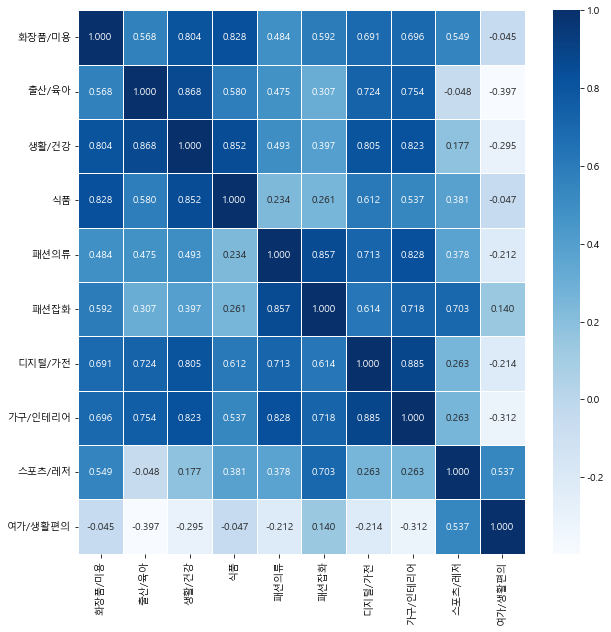

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data = df2.corr(), annot=True, 
fmt = '.3f', linewidths=.5, cmap='Blues')

In [ ]:
df2.set_index('날짜', inplace = True)
df2.head()

,화장품/미용,출산/육아,생활/건강,식품,패션의류,패션잡화,디지털/가전,가구/인테리어,스포츠/레저,여가/생활편의
날짜,,,,,,,,,,
2021-03-01,21.0,55.0,100.0,39.0,86.0,83.0,75.0,51.0,45.0,3.0
2021-03-02,19.0,49.0,91.0,37.0,61.0,62.0,67.0,39.0,36.0,3.0
2021-03-03,18.0,47.0,87.0,35.0,61.0,59.0,63.0,36.0,35.0,3.0
2021-03-04,18.0,47.0,85.0,35.0,63.0,59.0,63.0,36.0,34.0,3.0
2021-03-05,15.0,40.0,74.0,29.0,58.0,54.0,56.0,31.0,31.0,3.0


In [ ]:
chi_square_value, p_value = calculate_bartlett_sphericity(df2)
chi_square_value, p_value

(1700.6342003446177, 0.0)

In [ ]:
#KMO 검정 : 0.75로 우수한 데이터 
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df2)
kmo_model

0.758555876916214

In [ ]:
#요인 수 선택
fa = FactorAnalyzer(n_factors=10, rotation=None)
fa.fit(df2)

FactorAnalyzer(n_factors=10, rotation=None, rotation_kwargs={})

In [ ]:
ev, v = fa.get_eigenvalues()
ev

array([5.76570573, 2.00204142, 1.25864029, 0.42098425, 0.20713398,
       0.12415287, 0.10754132, 0.06707181, 0.03282592, 0.01390241])

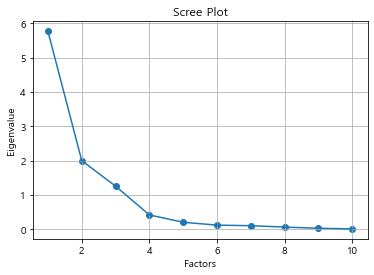

In [ ]:
plt.scatter(range(1, df2.shape[1]+1), ev)
plt.plot(range(1, df2.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
#eigen값 1 이상일 때까지 or 기울기 완만하기 전까지 

In [ ]:
#요인수 3개로 선택 
fa = FactorAnalyzer(n_factors=3, rotation=None)
fa.fit(df2)

FactorAnalyzer(rotation=None, rotation_kwargs={})

In [ ]:
efa_result = pd.DataFrame(fa.loadings_, index=df2.columns)
efa_result

,0,1,2
화장품/미용,0.845308,0.112996,0.317174
출산/육아,0.751863,-0.444661,0.008940
생활/건강,0.909406,-0.331056,0.255021
식품,0.738321,-0.093044,0.604290
패션의류,0.763690,0.174321,-0.546183
패션잡화,0.733410,0.553926,-0.356814
디지털/가전,0.882935,-0.104929,-0.094637
가구/인테리어,0.939209,-0.112387,-0.261677
스포츠/레저,0.440416,0.866030,0.232294
여가/생활편의,-0.182528,0.624705,0.257938


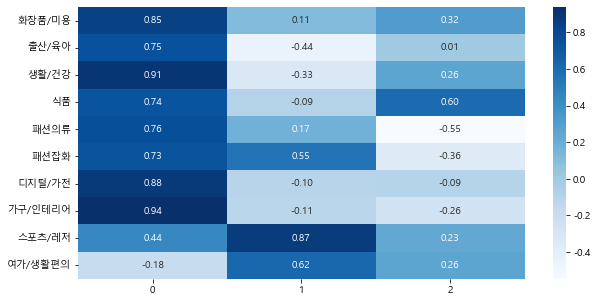

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(efa_result, cmap="Blues", annot=True, fmt='.2f')
plt.show()

In [ ]:
#최대우도 방법 선택 
fa_1 = FactorAnalyzer(n_factors=3, rotation="varimax")
fa_1.fit(df2)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [ ]:
efa_result_1 = pd.DataFrame(fa_1.loadings_, index=df2.columns)
efa_result_1

,0,1,2
화장품/미용,0.796619,0.367749,0.240981
출산/육아,0.688252,0.366489,-0.393823
생활/건강,0.925139,0.330179,-0.191713
식품,0.944502,0.039493,0.159050
패션의류,0.197243,0.933694,-0.035174
패션잡화,0.188126,0.886871,0.387439
디지털/가전,0.633877,0.619606,-0.117596
가구/인테리어,0.577174,0.771297,-0.187593
스포츠/레저,0.241192,0.368851,0.896499
여가/생활편의,-0.147131,-0.127130,0.672529


<AxesSubplot:>

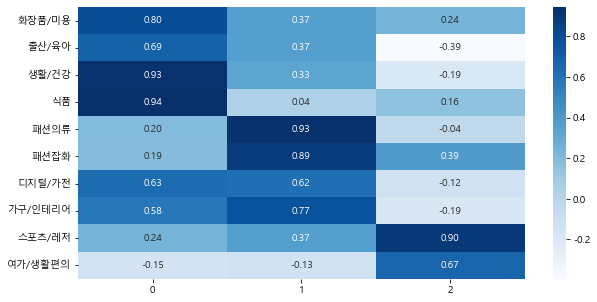

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(efa_result_1, cmap="Blues", annot=True, fmt='.2f')

In [ ]:
fa.get_factor_variance()
df2_1 = pd.DataFrame(fa_1.get_factor_variance())

df2_1.index=['SS Loadings', 'Proportion Var', 'Cumlative Var']
df2_1

,0,1,2
SS Loadings,3.745304,3.169479,1.731591
Proportion Var,0.374530,0.316948,0.173159
Cumlative Var,0.374530,0.691478,0.864637


In [ ]:
wth = df_wea_order.copy()

In [ ]:
shopping = df_org2.copy()

fact1 = ["화장품/미용", "생활/건강","식품","출산/육아"]
fact2 = ["패션의류", "패션잡화","가구인테리어" ,"디지털/가전"]
fact3 = ["스포츠/레저" , "여가/생활편의"]

shop_factor = pd.DataFrame({"BKG_DATE" : shopping['날짜'],
                            "Healthcare": shopping.filter(regex="|".join(fact1)).sum(axis=1),
                            "Lifestyle" : shopping.filter(regex="|".join(fact2)).sum(axis=1),
                            "Leisure" : shopping.filter(regex="|".join(fact3)).sum(axis=1)})

full = pd.merge(wth, shop_factor,on=['BKG_DATE'])

In [ ]:
cl = pd.DataFrame({"BKG_DATE" :full["BKG_DATE"],
                   "ITEM_QTY":full["ITEM_QTY"],
                   "SHPR_CD" : full['SHPR_CD'],
                   "ITEM_CD" : full['ITEM_CD'],
                   "Weather" : full['날씨지수'],
                   "Healthcare": full['Healthcare'],
                   "Lifestyle" : full['Lifestyle'],
                   "Leisure" : full['Leisure'],
                   "Day": full['day']})

In [ ]:
cl.head()

,BKG_DATE,ITEM_QTY,SHPR_CD,ITEM_CD,Weather,Healthcare,Lifestyle,Leisure,Day
0,2021-03-03,1,90001302,134265392,3.0,187.0,183.0,38.0,2
1,2021-03-03,1,90001542,3858391637,3.0,187.0,183.0,38.0,2
2,2021-03-03,1,90001341,5161458796,3.0,187.0,183.0,38.0,2
3,2021-03-03,1,90001441,4624200932,3.0,187.0,183.0,38.0,2
4,2021-03-03,1,90001541,4929464978,3.0,187.0,183.0,38.0,2


In [ ]:
df = cl[['Weather', 'Healthcare', 'Lifestyle', 'Leisure','Day']].copy()

In [ ]:
#표준정규분포를 활용한 Normalization 수행
data = (df-np.mean(df,axis=0))/np.std(df,axis=0)


In [ ]:
from minisom import MiniSom

from tqdm import tqdm, tqdm_notebook, tnrange
import time

In [ ]:
s_time = pd.Timestamp.now()
print('시작시간:',s_time,'\n')

#원하는 파라미터 조합 리스트화
map_n= [n for n in range(2,6)]
para_sigma= [np.round(sigma*0.1,2) for sigma in range(1,10)]
para_learning_rate= [np.round(learning_rate*0.1,2) for learning_rate in range(1,10)]

#결과 값을 담을 리스트 res 생성
res = []
#모든 조합에 대해 모델 생성 및 qe,te값 계산
for n in tqdm_notebook(map_n, desc = 'first'):
    for sigma in tqdm_notebook(para_sigma, desc = 'second'):
        for lr in tqdm_notebook(para_learning_rate, desc='third'):
            time.sleep(0.01)
            try:
                #랜덤으로 초기값을 설정하는 경우
                estimator = MiniSom(n,n,5,sigma =sigma, learning_rate = lr, topology='hexagonal',random_seed=0)
                estimator.random_weights_init(data.values)
                estimator.train(data.values,1000,random_order=True)
                qe = estimator.quantization_error(data.values)
                #te = estimator.topographic_error(data.values)
                winner_coordinates = np.array([estimator.winner(x) for x in data.values]).T
                cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
                res.append([str(n)+'x'+str(n),sigma,lr,'random_init',qe,len(np.unique(cluster_index))])

                #pca로 초기값을 설정하는 경우
                estimator = MiniSom(n,n,5,sigma =sigma, learning_rate = lr,topology='hexagonal', random_seed=0)
                estimator.pca_weights_init(data.values)
                estimator.train(data.values,1000,random_order=True)
                qe = estimator.quantization_error(data.values)
                #te = estimator.topographic_error(data.values)
                winner_coordinates = np.array([estimator.winner(x) for x in data.values]).T
                cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
                res.append([str(n)+'x'+str(n),sigma,lr,'pca_init',qe,len(np.unique(cluster_index))])
                
            except ValueError as e:
                print(e)
            
#결과 데이터프레임 생성 및 sorting 
df_res = pd.DataFrame(res,columns=['map_size','sigma','learning_rate','init_method','qe','n_cluster']) 
df_res.shape
df_res.sort_values(by=['qe'],ascending=True,inplace=True,ignore_index=True)
df_res.head(10)

#시각화를 위한 lineplot 생성
plt.figure(figsize=(20,10))
sns.lineplot(data = df_res)

e_time = pd.Timestamp.now()
print('\n종료시간:',e_time,'\n총 소요시간:',e_time-s_time)

시작시간: 2021-10-28 10:19:54.352853 



first:   0%|          | 0/4 [00:00<?, ?it/s]

second:   0%|          | 0/9 [00:00<?, ?it/s]

third:   0%|          | 0/9 [00:00<?, ?it/s]

third:   0%|          | 0/9 [00:00<?, ?it/s]

third:   0%|          | 0/9 [00:00<?, ?it/s]

third:   0%|          | 0/9 [00:00<?, ?it/s]

third:   0%|          | 0/9 [00:00<?, ?it/s]

third:   0%|          | 0/9 [00:00<?, ?it/s]

third:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df_res.head()

# 모델 파라미터 조정 

In [ ]:
#앞서 클러스터 개수가 16이면서 qe값이 가장 작게 나온 파라미터로 모델링 
som_b2 = MiniSom(4,4,5,sigma=0.5,learning_rate=0.1,topology='hexagonal',neighborhood_function='gaussian',activation_distance='euclidean', random_seed=0)
som_b2.random_weights_init(data.values)
som_b2.train(data.values,1000,random_order=True)

#평가
som_b2.quantization_error(data.values)

# 시각화

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import RegularPolygon

In [ ]:
#지정한 파라미터로 모델 생성 
estimator = MiniSom(4,4,5,sigma=0.5,learning_rate=0.1, topology='hexagonal',random_seed=0)
estimator.random_weights_init(data.values)
estimator.train(data.values,1000,random_order=True)
qe = estimator.quantization_error(data.values)

winner_coordinates = np.array([estimator.winner(x) for x in data.values]).T
cluster_index = np.ravel_multi_index(winner_coordinates,(4,4))

In [ ]:
xx, yy = som_b2.get_euclidean_coordinates()
umatrix = som_b2.distance_map()
weights = som_b2.get_weights()

f = plt.figure(figsize=(20,20))
ax = f.add_subplot(111)
ax.set_aspect('equal')

# iteratively add hexagons
# plotting the distance map as background
# 해당 셀과 다른 이웃들 간 거리를 표현, 밝을수록 가깝고, 어두울수록 멀다
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * 2 / np.sqrt(4) * 4 / 5
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        plot = ax.add_patch(hex)

#output노드에 해당하는 클러스터 종류 및 밀도 확인         
cnt=[]
for c in tqdm_notebook(np.unique(cluster_index)):
        time.sleep(0.01)
        x_= [som_b2.convert_map_to_euclidean(som_b2.winner(x))[0] + (2*np.random.rand(1)[0]-1)*0.4 for x in data.values[cluster_index==c]]
        y_= [som_b2.convert_map_to_euclidean(som_b2.winner(x))[1] + (2*np.random.rand(1)[0]-1)*0.4 for x in data.values[cluster_index==c]]
        y_= [(i* 2 / np.sqrt(4) * 4 / 5) for i in y_]
    
        plot = sns.scatterplot( x = x_,  y= y_ ,label='cluster='+str(c),alpha=.5, palette="pastel")
        
        #클러스터에 속한 데이터 개수 데이터프레임으로 출력
        cnt.append([c,len(x_)])

#클러스터별 개수를 표 형태로 출력 
df_cnt = pd.DataFrame(cnt,columns=['cluster이름','개수'])
df_cnt

#x축,y축 간격 설정 
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plot = plt.xticks(xrange-.5, xrange)
plot = plt.yticks(yrange * 2 / np.sqrt(4) * 4/ 5, yrange)

#차트 우측에 color bar생성
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
plot = cb1.ax.set_ylabel('distance from neurons in the neighborhood',
                  rotation=270, fontsize=16)
plot = plt.gcf().add_axes(ax_cb)

In [ ]:
df_cnt

In [ ]:
cluster_df = pd.DataFrame(cluster_index)
cluster_df.columns=['cluster']

cluster_df

In [ ]:
result = pd.concat([cl, cluster_df], axis=1)
result

In [ ]:
## 클러스터별 데이터프레임 생성 
cl0 = result[result['cluster']==0]
cl0 = cl0.drop(['cluster'], axis=1)

cl1 = result[result['cluster']==1]
cl1 = cl1.drop(['cluster'], axis=1)

cl2 = result[result['cluster']==2]
cl2 = cl2.drop(['cluster'], axis=1)

cl3 = result[result['cluster']==3]
cl3 = cl3.drop(['cluster'], axis=1)

cl4 = result[result['cluster']==4]
cl4 = cl4.drop(['cluster'], axis=1)

cl5 = result[result['cluster']==5]
cl5 = cl5.drop(['cluster'], axis=1)

cl6 = result[result['cluster']==6]
cl6 = cl6.drop(['cluster'], axis=1)

cl7 = result[result['cluster']==7]
cl7 = cl7.drop(['cluster'], axis=1)

cl8 = result[result['cluster']==8]
cl8 = cl8.drop(['cluster'], axis=1)

cl9 = result[result['cluster']==9]
cl9 = cl9.drop(['cluster'], axis=1)

cl10 = result[result['cluster']==10]
cl10 = cl10.drop(['cluster'], axis=1)

cl11 = result[result['cluster']==11]
cl11 = cl11.drop(['cluster'], axis=1)

cl12 = result[result['cluster']==12]
cl12 = cl12.drop(['cluster'], axis=1)

cl13 = result[result['cluster']==13]
cl13 = cl13.drop(['cluster'], axis=1)

cl14 = result[result['cluster']==14]
cl14 = cl14.drop(['cluster'], axis=1)

cl15 = result[result['cluster']==15]
cl15 = cl15.drop(['cluster'], axis=1)

# XGBoost

In [ ]:
from xgboost import XGBRegressor # 회귀트리 모델
from xgboost import plot_importance # 중요변수 시각화

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [ ]:
#  'SHPR_CD'로 그룹화 
grouped_0 = cl0.groupby('SHPR_CD').mean()
grouped_1 = cl1.groupby('SHPR_CD').mean()
grouped_2 = cl2.groupby('SHPR_CD').mean()
grouped_3 = cl3.groupby('SHPR_CD').mean()
grouped_4 = cl4.groupby('SHPR_CD').mean()
grouped_5 = cl5.groupby('SHPR_CD').mean()
grouped_6 = cl6.groupby('SHPR_CD').mean()
grouped_7 = cl7.groupby('SHPR_CD').mean()
grouped_8 = cl8.groupby('SHPR_CD').mean()
grouped_9 = cl9.groupby('SHPR_CD').mean()
grouped_10 = cl10.groupby('SHPR_CD').mean()
grouped_11 = cl11.groupby('SHPR_CD').mean()
grouped_12 = cl12.groupby('SHPR_CD').mean()
grouped_13 = cl13.groupby('SHPR_CD').mean()
grouped_14 = cl14.groupby('SHPR_CD').mean()
grouped_15 = cl15.groupby('SHPR_CD').mean()

### 훈련/테스트 구분 및 모델 생성

In [ ]:
y_target = grouped_0['ITEM_QTY']
X_features = grouped_0.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_0 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_0.fit(X_train,y_train)

In [ ]:
y_target = grouped_1['ITEM_QTY']
X_features = grouped_1.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_1 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_1.fit(X_train,y_train)

In [ ]:
y_target = grouped_2['ITEM_QTY']
X_features = grouped_2.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_2 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_2.fit(X_train,y_train)

In [ ]:
y_target = grouped_3['ITEM_QTY']
X_features = grouped_3.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_3 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_3.fit(X_train,y_train)

In [ ]:
y_target = grouped_4['ITEM_QTY']
X_features = grouped_4.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_4 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_4.fit(X_train,y_train)

In [ ]:
y_target = grouped_5['ITEM_QTY']
X_features = grouped_5.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_5 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_5.fit(X_train,y_train)

In [ ]:
y_target = grouped_6['ITEM_QTY']
X_features = grouped_6.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_6 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_6.fit(X_train,y_train)

In [ ]:
y_target = grouped_7['ITEM_QTY']
X_features = grouped_7.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_7 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_7.fit(X_train,y_train)

In [ ]:
y_target = grouped_8['ITEM_QTY']
X_features = grouped_8.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_8 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_8.fit(X_train,y_train)

In [ ]:
y_target = grouped_9['ITEM_QTY']
X_features = grouped_9.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_9 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_9.fit(X_train,y_train)

In [ ]:
y_target = grouped_10['ITEM_QTY']
X_features = grouped_10.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_10 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_10.fit(X_train,y_train)

In [ ]:
y_target = grouped_11['ITEM_QTY']
X_features = grouped_11.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_11 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_11.fit(X_train,y_train)

In [ ]:
y_target = grouped_12['ITEM_QTY']
X_features = grouped_12.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_12 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_12.fit(X_train,y_train)

In [ ]:
y_target = grouped_13['ITEM_QTY']
X_features = grouped_13.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_13 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_13.fit(X_train,y_train)

In [ ]:
y_target = grouped_14['ITEM_QTY']
X_features = grouped_14.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_14 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_14.fit(X_train,y_train)

In [ ]:
y_target = grouped_15['ITEM_QTY']
X_features = grouped_15.drop('ITEM_QTY', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,random_state=0)
xgb_model_15 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb_model_15.fit(X_train,y_train)

### RMSE: 예측성능 평가

In [ ]:
y_pred = xgb_model_0.predict(X_test)
rmse_0 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_0))

In [ ]:
y_pred = xgb_model_1.predict(X_test)
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_1))

In [ ]:
y_pred = xgb_model_2.predict(X_test)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_2))

In [ ]:
y_pred = xgb_model_3.predict(X_test)
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_3))

In [ ]:
y_pred = xgb_model_4.predict(X_test)
rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_4))

In [ ]:
y_pred = xgb_model_5.predict(X_test)
rmse_5 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_5))

In [ ]:
y_pred = xgb_model_6.predict(X_test)
rmse_6 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_6))

In [ ]:
y_pred = xgb_model_7.predict(X_test)
rmse_7 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_7))

In [ ]:
y_pred = xgb_model_8.predict(X_test)
rmse_8 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_8))

In [ ]:
y_pred = xgb_model_9.predict(X_test)
rmse_9 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_9))

In [ ]:
y_pred = xgb_model_10.predict(X_test)
rmse_10 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_10))

In [ ]:
y_pred = xgb_model_11.predict(X_test)
rmse_11 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_11))

In [ ]:
y_pred = xgb_model_12.predict(X_test)
rmse_12 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_12))

In [ ]:
y_pred = xgb_model_13.predict(X_test)
rmse_13 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_13))

In [ ]:
y_pred = xgb_model_14.predict(X_test)
rmse_14 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_14))

In [ ]:
y_pred = xgb_model_15.predict(X_test)
rmse_15 = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_15))

In [ ]:
RMSE = pd.DataFrame(
                {'cluster' : [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                 'rmse' : [rmse_0,rmse_1, rmse_2, rmse_3, rmse_4, rmse_5,rmse_6,rmse_7,rmse_8,rmse_9,rmse_10,rmse_11,rmse_12,rmse_13, rmse_14,rmse_15]})
RMSE.set_index('cluster')

### 변수 중요도 (Feature Importance)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25,25))
axes = [ax for row_axes in axes for ax in row_axes]
plot_importance(xgb_model_0, ax = axes[0], title='cluster0',height=0.5)
plot_importance(xgb_model_1, ax = axes[1], title='cluster1',height=0.5)
plot_importance(xgb_model_2, ax = axes[2], title='cluster2',height=0.5)
plot_importance(xgb_model_3, ax = axes[3], title='cluster3',height=0.5)
plot_importance(xgb_model_4, ax = axes[4], title='cluster4',height=0.5)
plot_importance(xgb_model_5, ax = axes[5], title='cluster5',height=0.5)
plot_importance(xgb_model_6, ax = axes[6], title='cluster6',height=0.5)
plot_importance(xgb_model_7, ax = axes[7], title='cluster7',height=0.5)
plot_importance(xgb_model_8, ax = axes[8], title='cluster8',height=0.5)
plot_importance(xgb_model_9, ax = axes[9], title='cluster9',height=0.5)
plot_importance(xgb_model_10, ax = axes[10], title='cluster10',height=0.5)
plot_importance(xgb_model_11, ax = axes[11], title='cluster11',height=0.5)
plot_importance(xgb_model_12, ax = axes[12], title='cluster12',height=0.5)
plot_importance(xgb_model_13, ax = axes[13], title='cluster13',height=0.5)
plot_importance(xgb_model_14, ax = axes[14], title='cluster14',height=0.5)
plot_importance(xgb_model_15, ax = axes[15], title='cluster15',height=0.5)
plt.show()

# Prophet 시계열 예측

### 1) 클러스터별 수량 예측

In [ ]:
cl0_fc = cl0[['BKG_DATE', 'ITEM_QTY']].copy()
cl0_fc.columns = ['ds', 'y']
cl0_fc['ds'] = pd.to_datetime(cl0_fc['ds'])

cl1_fc = cl1[['BKG_DATE', 'ITEM_QTY']].copy()
cl1_fc.columns = ['ds', 'y']
cl1_fc['ds'] = pd.to_datetime(cl1_fc['ds'])

cl2_fc = cl2[['BKG_DATE', 'ITEM_QTY']].copy()
cl2_fc.columns = ['ds', 'y']
cl2_fc['ds'] = pd.to_datetime(cl2_fc['ds'])

cl3_fc = cl3[['BKG_DATE', 'ITEM_QTY']].copy()
cl3_fc.columns = ['ds', 'y']
cl3_fc['ds'] = pd.to_datetime(cl3_fc['ds'])

cl4_fc = cl4[['BKG_DATE', 'ITEM_QTY']].copy()
cl4_fc.columns = ['ds', 'y']
cl4_fc['ds'] = pd.to_datetime(cl4_fc['ds'])

cl5_fc = cl5[['BKG_DATE', 'ITEM_QTY']].copy()
cl5_fc.columns = ['ds', 'y']
cl5_fc['ds'] = pd.to_datetime(cl5_fc['ds'])

cl6_fc = cl6[['BKG_DATE', 'ITEM_QTY']].copy()
cl6_fc.columns = ['ds', 'y']
cl6_fc['ds'] = pd.to_datetime(cl6_fc['ds'])

cl7_fc = cl7[['BKG_DATE', 'ITEM_QTY']].copy()
cl7_fc.columns = ['ds', 'y']
cl7_fc['ds'] = pd.to_datetime(cl7_fc['ds'])

cl8_fc = cl8[['BKG_DATE', 'ITEM_QTY']].copy()
cl8_fc.columns = ['ds', 'y']
cl8_fc['ds'] = pd.to_datetime(cl8_fc['ds'])

cl9_fc = cl9[['BKG_DATE', 'ITEM_QTY']].copy()
cl9_fc.columns = ['ds', 'y']
cl9_fc['ds'] = pd.to_datetime(cl9_fc['ds'])

cl10_fc = cl10[['BKG_DATE', 'ITEM_QTY']].copy()
cl10_fc.columns = ['ds', 'y']
cl10_fc['ds'] = pd.to_datetime(cl10_fc['ds'])

cl11_fc = cl11[['BKG_DATE', 'ITEM_QTY']].copy()
cl11_fc.columns = ['ds', 'y']
cl11_fc['ds'] = pd.to_datetime(cl11_fc['ds'])

cl12_fc = cl12[['BKG_DATE', 'ITEM_QTY']].copy()
cl12_fc.columns = ['ds', 'y']
cl12_fc['ds'] = pd.to_datetime(cl12_fc['ds'])

cl13_fc = cl13[['BKG_DATE', 'ITEM_QTY']].copy()
cl13_fc.columns = ['ds', 'y']
cl13_fc['ds'] = pd.to_datetime(cl13_fc['ds'])

cl14_fc = cl14[['BKG_DATE', 'ITEM_QTY']].copy()
cl14_fc.columns = ['ds', 'y']
cl14_fc['ds'] = pd.to_datetime(cl14_fc['ds'])

cl15_fc = cl15[['BKG_DATE', 'ITEM_QTY']].copy()
cl15_fc.columns = ['ds', 'y']
cl15_fc['ds'] = pd.to_datetime(cl15_fc['ds'])

#### 클러스터별 Prophet 모델 생성

In [ ]:
m0 = Prophet()
m0.fit(cl0_fc)

In [ ]:
m1 = Prophet()
m1.fit(cl1_fc)

In [ ]:
m2 = Prophet()
m2.fit(cl2_fc)

In [ ]:
m3 = Prophet()
m3.fit(cl3_fc)

In [ ]:
m4 = Prophet()
m4.fit(cl4_fc)

In [ ]:
m5 = Prophet()
m5.fit(cl5_fc)

In [ ]:
m6 = Prophet()
m6.fit(cl6_fc)

In [ ]:
m7 = Prophet()
m7.fit(cl7_fc)

In [ ]:
m8 = Prophet()
m8.fit(cl8_fc)

In [ ]:
m9 = Prophet()
m9.fit(cl9_fc)

In [ ]:
m10 = Prophet()
m10.fit(cl10_fc)

In [ ]:
m11 = Prophet()
m11.fit(cl11_fc)

In [ ]:
m12 = Prophet()
m12.fit(cl12_fc)

In [ ]:
m13 = Prophet()
m13.fit(cl13_fc)

In [ ]:
m14 = Prophet()
m14.fit(cl14_fc)

In [ ]:
m15 = Prophet()
m15.fit(cl15_fc)

#### Forecasting (향후 100일)

In [ ]:
future0 = m0.make_future_dataframe(periods=100)
forecast0 = m0.predict(future0)

future1 = m1.make_future_dataframe(periods=100)
forecast1 = m1.predict(future1)

future2 = m2.make_future_dataframe(periods=100)
forecast2 = m2.predict(future2)

future3 = m3.make_future_dataframe(periods=100)
forecast3 = m3.predict(future3)

future4 = m4.make_future_dataframe(periods=100)
forecast4 = m4.predict(future4)

future5 = m5.make_future_dataframe(periods=100)
forecast5 = m5.predict(future5)

future6 = m6.make_future_dataframe(periods=100)
forecast6 = m6.predict(future6)

future7 = m7.make_future_dataframe(periods=100)
forecast7 = m7.predict(future7)

future8 = m8.make_future_dataframe(periods=100)
forecast8 = m8.predict(future8)

future9 = m9.make_future_dataframe(periods=100)
forecast9 = m9.predict(future9)

future10 = m10.make_future_dataframe(periods=100)
forecast10 = m10.predict(future10)

future11 = m11.make_future_dataframe(periods=100)
forecast11 = m11.predict(future11)

future12 = m12.make_future_dataframe(periods=100)
forecast12 = m12.predict(future12)

future13 = m13.make_future_dataframe(periods=100)
forecast13 = m13.predict(future13)

future14 = m14.make_future_dataframe(periods=100)
forecast14 = m14.predict(future14)

future15 = m15.make_future_dataframe(periods=100)
forecast15 = m15.predict(future15)

#### 시각화 

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25,25))
axes = [ax for row_axes in axes for ax in row_axes]

m0.plot(forecast0, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[0])
m1.plot(forecast1, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[1])
m2.plot(forecast2, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[2])
m3.plot(forecast3, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[3])
m4.plot(forecast4, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[4])
m5.plot(forecast5, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[5])
m6.plot(forecast6, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[6])
m7.plot(forecast7, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[7])
m8.plot(forecast8, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[8])
m9.plot(forecast9, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[9])
m10.plot(forecast10, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[10])
m11.plot(forecast11, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[11])
m12.plot(forecast12, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[12])
m13.plot(forecast13, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[13])
m14.plot(forecast14, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[14])
m15.plot(forecast15, xlabel='Date', ylabel='ITME_QUANTITIY', ax = axes[15])

In [ ]:
m0.plot_components(forecast0)

### 2) 쇼핑몰별 수량 예측

In [ ]:
result_df = result[result['SHPR_CD']==90001302]
result_df = result_df.sort_values("BKG_DATE")

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(result_df['BKG_DATE'], result_df['ITEM_QTY'])

In [ ]:
result_df_sample = result_df.rename(columns={'BKG_DATE':'ds', 'ITEM_QTY':'y'})

In [ ]:
m = Prophet()
m.fit(result_df_sample)
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

#### 시각화

In [ ]:
figure = m.plot(forecast, xlabel='Date', ylabel='ITEM_QTY')

In [ ]:
figure3 = m.plot_components(forecast)

#스크래핑

In [ ]:
cj_data_path = "/CJ 2021년 미래기술 챌린지 이커머스 FC주문 데이터.pickle"
connection_failed_path = "/바탕화면/connection_failed.txt"
ITEM_NM_dict_path = "/바탕화면/ITEM_NM_dict.pickle"

In [ ]:
manager = Manager()
ITEM_NM_dict = manager.dict(zip([], [[]]))
not_operational_list = manager.list()

In [ ]:
cj_data_df = pd.read_pickle(cj_data_path)
len(cj_data_df)

- 스크래핑 함수

In [ ]:
cj_data_gen = (i for i in cj_data_df["ITEM_CD"])def scrape(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36"
        }
        req = requests.get(url, headers=headers, timeout=5, allow_redirects=True).text
        raw_title = fromstring(req).xpath("./head/title")
        title = tostring(raw_title[0], encoding="unicode")
        if "상품이 존재하지 않습니다." in title or "현재 운영되고 있지 않습니다." in title:
            not_operational_list.append(f"{url} {str(dt.now())}")
        else:
            title_tag = str(title)[7:-13]
            ITEM_CD = url[38:-1]
            if ITEM_CD not in ITEM_NM_dict:
                ITEM_NM_dict[ITEM_CD] = title_tag
        return False
    except Exception:
        return url

- 실패 항목 재 스크래핑 함수

In [ ]:
def excep_scrape(excep_url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36"
        }
        req = requests.get(excep_url, headers=headers, timeout=5, allow_redirects=True).text
        raw_title = fromstring(req).xpath("./head/title")
        title = tostring(raw_title[0], encoding="unicode")
        if "상품이 존재하지 않습니다." in title or "현재 운영되고 있지 않습니다." in title:
            not_operational_list.append(f"{excep_url} {str(dt.now())}")
        else:
            title_tag = str(title)[7:-13]
            ITEM_CD = excep_url[38:-1]
            if ITEM_CD not in ITEM_NM_dict:
                ITEM_NM_dict[ITEM_CD] = title_tag
        return False
    except Exception:
        with open(connection_failed_path, mode="at", encoding="utf-8-sig") as f:
            f.write(f"{excep_url} {str(dt.now())}\n")
        return excep_url

- 스크래핑 결과 요약 함수

In [ ]:
def summary(total, excep, failed):
    m, s = divmod(time.time() - start_time, 60)
    h, m = divmod(m, 60)
    print("\n####################SUMMARY####################")
    print(f"  scraping finished at {str(dt.now())} properly.")
    print(f"  Total {total - failed} urls successfully passed,"
          f"\n  {excep} exception(s) occured,"
          f"\n  and finally {failed} url(s) unabled to scrape.")
    print(f"           --- total progress time {int(h)}h {int(m)}m {int(s)}s ---")
    print("###############################################\n")

- 스크래핑 본체 함수

In [ ]:
def run(proc, total, re):
    proc, total, excep, failed = proc, total, 0, 0

    print(f"\nbrand.naver scraping started at {str(dt.now())}\n")
    pool = Pool(processes=proc)
    if re == 'n':
        urls = (f"https://brand.naver.com/main/products/{str(url)}/" for url in cj_data_gen)
        excep_urls = [i for i in
                      tqdm(pool.imap_unordered(scrape, urls), total=total, desc="scraping", leave=False, ascii=True, ncols=100)
                      if i is not False]
        failed_urls = [i for i in tqdm(pool.imap_unordered(excep_scrape, excep_urls), total=len(excep_urls),
                                        desc="exception", leave=False, ascii=True, ncols=100) if i is not False]
        write_pickle(ITEM_NM_dict_path, ITEM_NM_dict)
        summary(total, len(excep_urls), len(failed_urls))
        return
    else:
        with open(connection_failed_path, mode="r", encoding="utf-8-sig") as f:
            urls = [i.split()[0] for i in f.readlines()]
            print(f"{len(urls)} urls are going to rescrape now...")
            excep_urls = [i for i in
                          tqdm(pool.imap_unordered(scrape, urls), total=len(urls), desc="scraping", leave=False, ascii=True, ncols=100)
                          if i is not False]
            failed_urls = [i for i in
                            tqdm(pool.imap_unordered(excep_scrape, excep_urls), total=len(excep_urls),
                                desc="exception", leave=False, ascii=True, ncols=100) if i is not False]
            write_pickle(ITEM_NM_dict_path, ITEM_NM_dict)
            summary(len(urls), len(excep_urls), len(failed_urls))
        if len(failed_urls) == 0 and os.path.isfile(connection_failed_path):
            os.remove(connection_failed_path)
            print("connection_failed.txt has been deleted.\n")
        return

In [ ]:
start_time = time.time()

#프로세스 수, 스크래핑 길이, 재탐색 여부
run(150, len(cj_data_df), 'n')

In [ ]:
ITEM_NM_dict = pd.read_pickle(ITEM_NM_dict_path)
print(len(ITEM_NM_dict))
print(ITEM_NM_dict)